In [16]:
from pgljupyter import LsystemWidget

In [72]:
from openalea.mtg import *
from pickle import load

In [18]:
mango = load(open('mangomtg.pkl','rb'))

In [93]:
TreeScale = 1
GUScale = 2

InfloLabel = 'Inflorescence'
FruitLabel = 'Fruit'
GULabel = 'GU'

CyclePropertyName = 'cycle'

BurstDatePropertyName = 'burst_date'

NbFruitPropertyName = 'nb_fruits'
FruitWeightPropertyName = 'fruits_weight'
FruitHarvestDatePropertyName = 'fruits_maturity_date'

def is_inflorescence(mtg, unit):
    return mtg.label(unit) == InfloLabel

def is_fruit(mtg, unit):
    return mtg.label(unit) == FruitLabel

def is_gu(mtg, unit):
    return mtg.label(unit) == GULabel

def get_gus(mtg):
    return [i for i in mtg.components_at_scale(mtg.roots()[0],scale=GUScale) if is_gu(mtg,i) ]

def get_inflorescences(mtg):
    return [i for i in mtg.components_at_scale(mtg.roots()[0],scale=GUScale) if is_inflorescence(mtg,i) ]

def vegetative_children(mtg, unit):
    return [child for child in mtg.children(unit) if is_gu(mtg,child)]

def get_unit_cycle(mtg, unit, default = 3):
    """Return the cycle of the unit. Default cycle is default. """
    return mtg.property(CyclePropertyName).get(unit, default)        

def get_burst_date(mtg, unit, default=None):
  """Return the date of burst of the unit.  """
  return mtg.property(BurstDatePropertyName).get(unit, default)

def get_nb_fruits(mtg, inflo, default=0):
    return mtg.property(NbFruitPropertyName).get(inflo,default)

def get_fruits_weight(mtg, inflo, default = 0):
    return mtg.property(FruitWeightPropertyName).get(inflo,default)

def get_fruits_harvest_date(mtg, inflo, default = None):
    return mtg.property(FruitHarvestDatePropertyName).get(inflo,default)



# Fruit production

We compute the distribution of estimated harvest date

In [74]:
from openalea.vmango.utilities.util_date import *
from collections import OrderedDict
harvestdaterange = (weekdate_range(fruiting_cycle_begin(4),fruiting_cycle_end(4)+ timedelta(days=21)))

In [75]:

def harvest_week_distribution(mtg):
    def toweekid(date):
        if date is None: return None
        d = date.isocalendar()
        return (d[0],d[1]) 

    histo_date = OrderedDict([(d,0) for d in harvestdaterange])
    fruit_weights = []
    for unit in get_inflorescences(mtg):
      if get_unit_cycle(mtg, unit) == 4:
        nbfruits = get_nb_fruits(mtg,unit)
        if nbfruits > 0:
           harvest = get_fruits_harvest_date(mtg,unit)
           wid = toweekid(harvest)
           if not wid in histo_date:
              print('Cannot consider',wid)
           else:
               histo_date[wid] += nbfruits
           fruit_weights.append(get_fruits_weight(mtg, unit))
        
    return list(histo_date.values()), fruit_weights



In [76]:
def plot_harvest_distribution(values):
    import matplotlib.pyplot as plt
    #strdate = lambda d : str(d[1])# +'-'+str(d[0]-2000)
    dates     = list(map(lambda d : str(d[1])+'/'+str(d[0])[2:], harvestdaterange))
    fig, ax = plt.subplots()
    plt.bar(dates,values)
    ax.set_xticklabels(dates, rotation=80)
    plt.xlabel('Weeks'); plt.ylabel('Number of fruits')
    plt.plot()
    
def plot_weight_distribution(values):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.hist(weigths,range(0,1200,100))
    plt.xlabel('Weights'); plt.ylabel('Number of fruits')
    plt.plot()

<ipython-input-76-87df6d44f967>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=80)


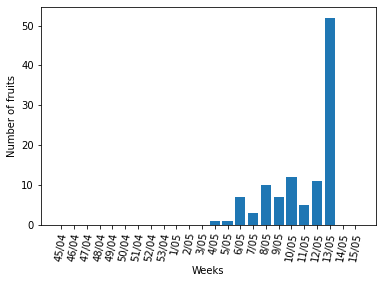

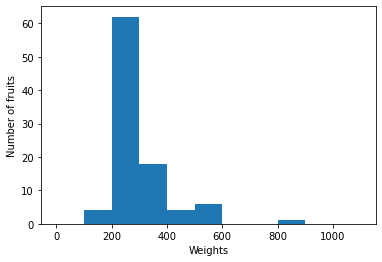

In [77]:
harvest, weigths = harvest_week_distribution(mango)
plot_harvest_distribution(harvest)
plot_weight_distribution(weigths)

## GU distribution

We give here an algorithm to determine the number of GUs appearing each month of the simulated period. For this we simply check the burst date of each GU.

In [78]:
daterange = monthdate_range(vegetative_cycle_end(3),vegetative_cycle_end(5))

def determine_gu_distribution(mtg):
    histo_date = OrderedDict([(d,0) for d in daterange])
    for uc in get_gus(mtg):
        try:
            d = get_burst_date(mtg,uc)
            histo_date[(d.year,d.month)] += 1
        except : pass
    return list(histo_date.values())

def plot_distribution(values):
    import matplotlib.pyplot as plt
    dates     = list(map(lambda d : MonthEnName[d[1]][:3]+'-'+str(d[0]-2000).zfill(2), daterange))
    fig, ax = plt.subplots()
    plt.bar(dates,values)
    ax.set_xticklabels(dates, rotation=80)
    plt.xlabel('Month'); plt.ylabel('Number of new growth units')

<ipython-input-78-d0cb87e50d2f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=80)


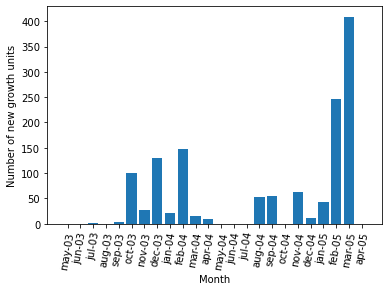

In [79]:
gudistrib = determine_gu_distribution(mango)
plot_distribution(gudistrib)

## Current Year Axes Size Distribution

The number of GUs borned from the same initial GU of the initial structure is computed. The distribution of size is then displayed. This allow to compare vigour of the different initial GUs.

In [80]:
import numpy as np

def determine_length_histogram(mtg):
    ucs = [uc for uc in get_gus(mtg) if get_unit_cycle(mtg, uc) > 3]
    roots = [uc for uc in ucs if get_unit_cycle(mtg,uc) != get_unit_cycle(mtg,mtg.parent(uc))]
    groupid = dict([(uc,uc) for uc in  roots])
    for uc in ucs :       
        if not uc in groupid:
            parents = []
            while not uc in groupid:
                parents.append(uc)
                uc = mtg.parent(uc)
            gid = groupid[uc]
            for p in parents:
                groupid[p] = gid
    histo = np.bincount(np.bincount(list(groupid.values())))[1:]
    return histo

def plot_length_histogram(values):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.bar(range(len(values)),values)
    #ax.set_xticklabels(dates, rotation=80)
    plt.title('Current Year Axes Size Distribution')
    plt.xlabel('Number of GUs in current year axes'); plt.ylabel('Number of current year axes')

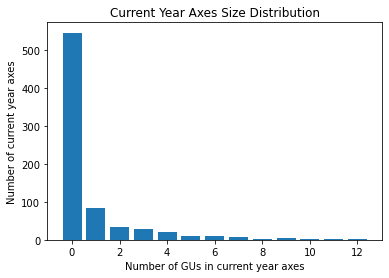

In [81]:
h = determine_length_histogram(mango)
plot_length_histogram(h)

## Building Fruiting branches

In [98]:
from functools import reduce

def neighbours(mtg, node):
    """ Gives the neighbours of a node in the mtg. In a tree graph, it is the parent and the children """
    parent = mtg.parent(node)
    if parent: return [parent]+vegetative_children(mtg,node)
    else: return vegetative_children(mtg,node)

def nodes_at_distance(mtg, node, distance):
    """ Return all nodes at a distance of node in the mtg. A set is returned """
    orderi = neighbours(mtg, node)
    res = set(orderi)
    for j in range(1,distance):
        orderj = []
        for ni in orderi:
            if j < distance:
                candidates = neighbours(mtg, ni)
                orderj += [nj for nj in candidates if not nj in res]
        res |= set(orderj)
        orderi = orderj
    return res


def determine_fruiting_structure(mtg, cycle, fruit_distance):
    """ Determine the different fruiting branches.
        For this the different inflorescences that will gives fruits are first located. 
        All growth units at a given distance are associated with the inflo, forming a fruiting branches.
        If two set of growth units have common elements, the fruiting branches are merged.
        Return a list of tuple. Each tuple contains first a list of id of inflorescences and second a set of id of growth units.
    """
    def merge(supporti, supportj):
        return supporti[0]+supportj[0], supporti[1] | supportj[1]
    
    inflo = [inflo for inflo in get_inflorescences(mtg) if get_unit_cycle(mtg, inflo) == cycle and get_nb_fruits(mtg,inflo) > 0]
    inflo_support = [([i],nodes_at_distance(mtg,i,fruit_distance)) for i in inflo]

    i = 0
    to_merge_at_last = []
    while i < len(inflo_support):
        # We first test if inflo_support[i] has common elements with others.
        tomerge = []
        for j in range(i+1,len(inflo_support)):
            if len(inflo_support[i][1] & inflo_support[j][1]) > 0 : 
                # The 2 sets have elements in common
                tomerge.append(j)

        # We merge the elements
        if len(tomerge) > 0:
            to_merge_at_last.append((i,inflo_support[i]))
            tomerge.sort()
            inflo_support[i] = reduce(merge, [inflo_support[m] for m in tomerge])
            for m in reversed(tomerge): del inflo_support[m]
        else:
            i += 1

    for i, m in to_merge_at_last:
        inflo_support[i] = merge(inflo_support[i], m)

    return inflo_support

In [109]:
def fb_sizes(fb):
    return [len(gus) for inflos,gus in fb]

def plot_fb_histogram(values):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.boxplot([fb_sizes(count) for c,count in values],labels=[c for c,count in values])
    #plt.bar(range(len(values)),values)
    plt.title('Fruiting branches size')
    plt.xlabel('Cycle'); plt.ylabel('Number of GUs in fruiting branches')


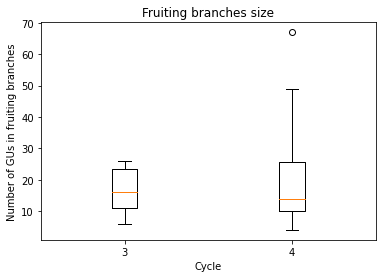

In [120]:
branchsize = 4
fruiting_branches = [(c,determine_fruiting_structure(mango,c,branchsize)) for c in range(3,5)]
plot_fb_histogram(fruiting_branches)

# Using xarray for properties